In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
%matplotlib inline

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cali*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)

cv2.destroyAllWindows()

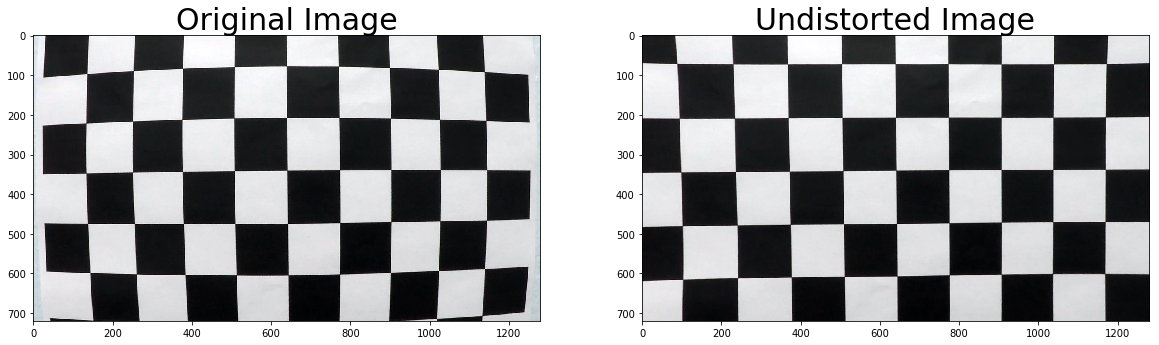

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_calibration_1.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
import pickle
dist_pickle_loaded = {}
dist_pickle_loaded = pickle.load(open( "camera_cal/wide_dist_pickle.p", "rb"))

mtx = dist_pickle_loaded["mtx"]
dist = dist_pickle_loaded["dist"]

In [44]:
ym_per_pix = 10/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700

def sliding_window(warped_bin):
    global left_fit
    global right_fit

    histogramx = np.sum(warped_bin[warped_bin.shape[0]//2:, :], axis=0)
    histogramy = np.sum(warped_bin[warped_bin.shape[0]//2:, :], axis=1)
    
    out_img = np.dstack((warped_bin, warped_bin, warped_bin)) * 255
    
    midpoint = np.int(len(histogramx)/2)
    leftx_base = np.argmax(histogramx[:midpoint])
    rightx_base = np.argmax(histogramx[midpoint:]) + midpoint
    
    nwindows = 9
    window_height = np.int(warped_bin.shape[0]/nwindows)
    
    nonzero = warped_bin.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]

    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100
    minpix = 70

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = warped_bin.shape[0] - (window+1)*window_height
        win_y_high = warped_bin.shape[0] - (window)*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_r = 0
    right_r = 0
    center_dist = 0
    # Fit a second order polynomial to each
    if len(leftx) != 0 and len(lefty) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_r = compute_rad_curv(leftx, lefty)
    if len(rightx) != 0 and len(righty) != 0:
        right_r = compute_rad_curv(rightx, righty)
        if right_r > 100 and right_r < 2000:
            right_fit = np.polyfit(righty, rightx, 2)
            
    if right_fit is not None and left_fit is not None:
        h = warped_bin.shape[0]
        car_position = warped_bin.shape[1]/2
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    
    return left_fit, right_fit, left_r, right_r, center_dist

In [6]:
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

In [19]:
def draw_lane(original_img, binary_img, l_fit, r_fit, src, dst):
    global Minv
    
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        print("in draw found l_fit/r_fit None: ", l_fit, r_fit)
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warped(color_warp, Minv)
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

In [41]:
import numpy as np

SLIDING_WINDOW_UPDATE = 20

left_fit = None
right_fit = None

def undistort(image, mtx, dist):
    return cv2.undistort(image, mtx, dist, None, mtx)

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]

    thresh = (150, 255)
    hls_bin = np.zeros_like(S)
    hls_bin[(S > thresh[0]) & (S <= thresh[1])] = 1
    # Apply cv2.Sobel()
    sobelx = cv2.Sobel(hls_bin, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(hls_bin, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    if orient == 'x':
        # Take the absolute value of the output from cv2.Sobel()
        abs_sobel = np.absolute(sobelx)
    else:
        abs_sobel = np.absolute(sobely)
    # Scale the result to an 8-bit range (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply lower and upper thresholds
    # Create binary_output
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

# src =  np.float32([[900, 450], [1200, 700], [200, 700], [500, 450]])
src =  np.float32([[850, 500], [1200, 700], [200, 700], [500, 500]])
dst = np.float32([[1280, 0], [1280, 720], [0, 720], [0, 0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def warped(image, m=M):
    warped = cv2.warpPerspective(image, m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

image = None
undistorted_img = None
warped_img = None
result = None

def compute_rad_curv(xvals, yvals):
    fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
    y_eval = np.max(yvals)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad



def process_image(image):
    global mtx
    global dist
    global left_fit
    global right_fit
    global i
    
    global image_copy
    global undistorted_img
    global warped_img
    global result
    
    
    image_copy = np.copy(image)
    
    undistorted_img = undistort(image, mtx, dist)
    
    warped_img = warped(undistorted_img, M)
    
    abs_sobel_img = abs_sobel_thresh(warped_img, orient='x', sobel_kernel=9, thresh_min=20, thresh_max=100)
    
    # binary image to draw on.
    out_img = np.dstack((abs_sobel_img, abs_sobel_img, abs_sobel_img)) * 255
    
#     if (i % SLIDING_WINDOW_UPDATE == 0) :
#         left_fit, right_fit = sliding_window(abs_sobel_img)        
#     i += 1

    left_fit, right_fit, left_r, right_r, center_dist = sliding_window(abs_sobel_img)
#     if left_fit is None or right_fit is None:
#         left_fit, right_fit = sliding_window(abs_sobel_img)
#         print("Sliding 1")
#     else:
#         left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit_using_prev_fit(abs_sobel_img, left_fit, right_fit)
#         print("polyfit")
        
#     if left_fit is None or right_fit is None:
#         left_fit, right_fit = sliding_window(abs_sobel_img)
#         print("Sliding 2")
    
    result = draw_lane(image_copy, abs_sobel_img, left_fit, right_fit, dst, src)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Left radius of curvature  = %.2f m'%(left_r),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Right radius of curvature = %.2f m'%(right_r),(50,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Distance from lane center = %.2f m'%(center_dist),(50,110), font, 1,(255,255,255),2,cv2.LINE_AA)

    return result
        
#     inverse perspective trasform
#     return result

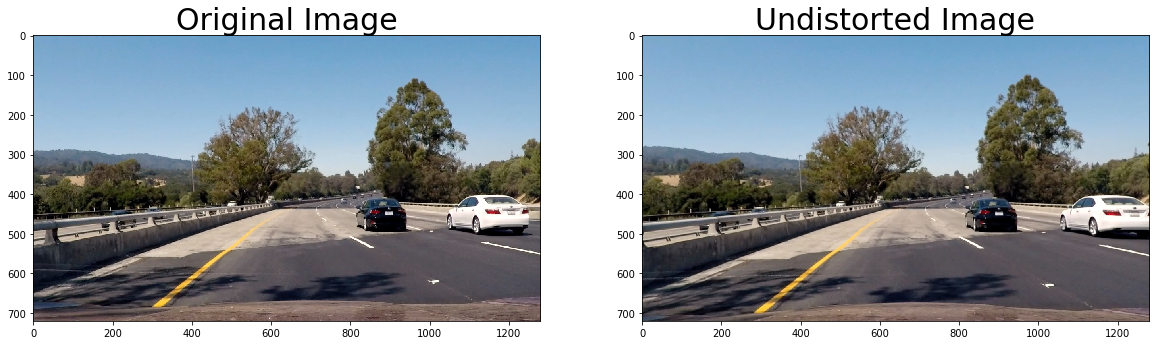

In [9]:
sample_img = mpimg.imread("test_images/test4.jpg")
undistort_img = undistort(sample_img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistort_img)
ax2.set_title('Undistorted Image', fontsize=30)

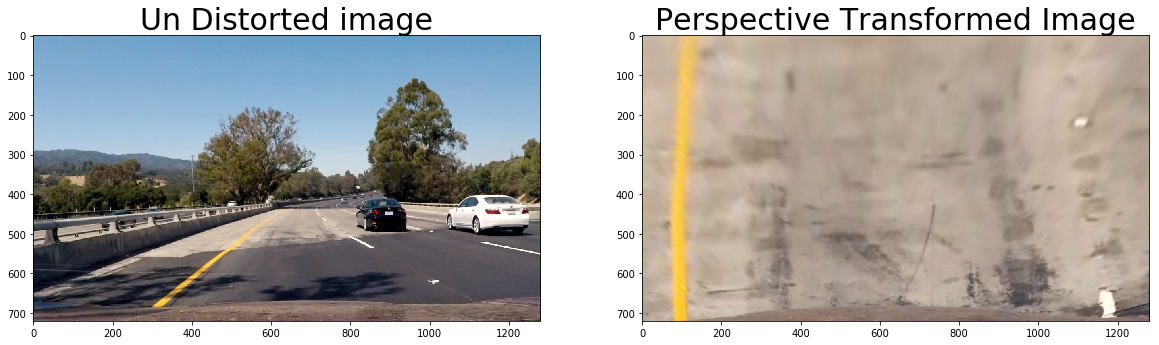

In [27]:
sample_img = mpimg.imread("test_images/test4.jpg")
undistort_img = undistort(sample_img, mtx, dist)
warped_img = warped(undistorted_img, M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(sample_img)
ax1.set_title('Un Distorted image', fontsize=30)
ax2.imshow(warped_img)
ax2.set_title('Perspective Transformed Image', fontsize=30)

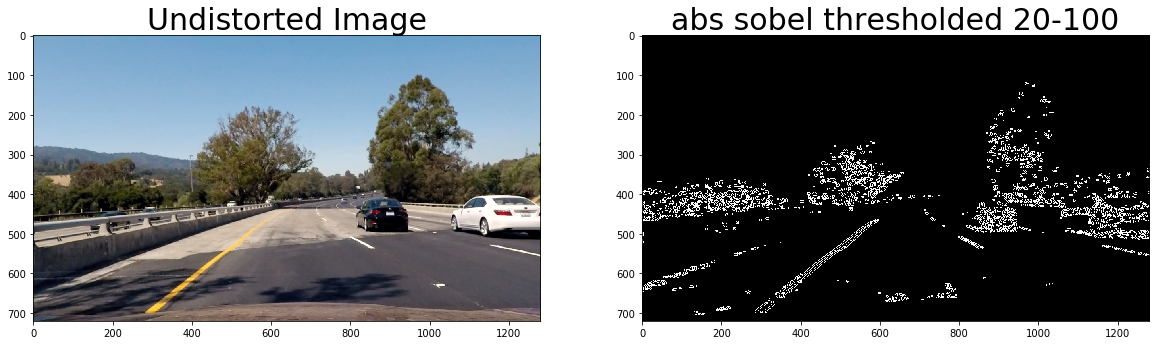

In [10]:
abs_sobel_img = abs_sobel_thresh(undistort_img, orient='x', sobel_kernel=9, thresh_min=20, thresh_max=100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistort_img)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(abs_sobel_img, cmap='gray')
ax2.set_title('abs sobel thresholded 20-100', fontsize=30)

Sobel Y was not giving good results on gray image. Sobel X also was not performing at places where road has shade and light. HLS s threshold gave better results on those wile the performance on normal roads are not on par with gray scale.

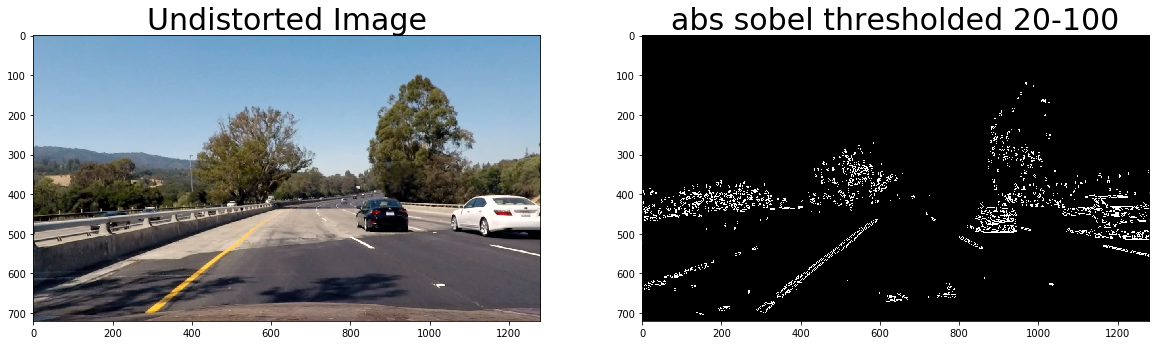

In [11]:
abs_sobel_img = abs_sobel_thresh(undistort_img, orient='y', sobel_kernel=9, thresh_min=70, thresh_max=170)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistort_img)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(abs_sobel_img, cmap='gray')
ax2.set_title('abs sobel thresholded 20-100', fontsize=30)

Testing on another image.

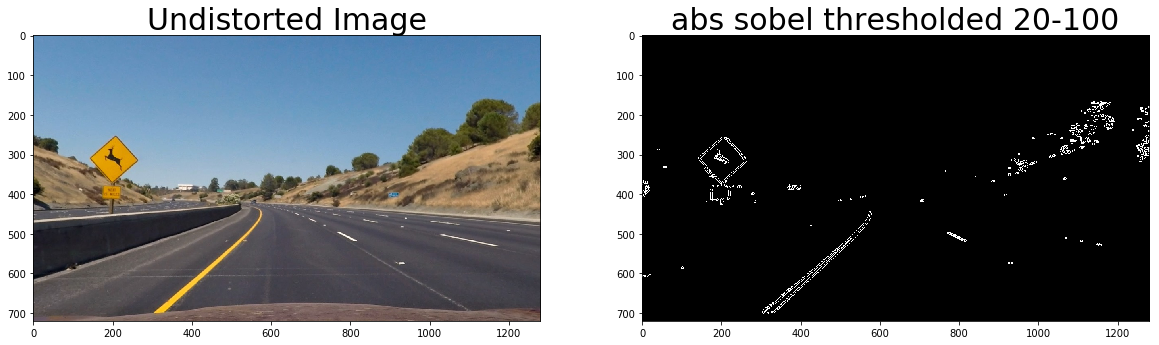

In [12]:
sample_img1 = mpimg.imread("test_images/test2.jpg")
undistort_img1 = undistort(sample_img1, mtx, dist)

abs_sobel_img1 = abs_sobel_thresh(undistort_img1, orient='x', sobel_kernel=9, thresh_min=20, thresh_max=100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistort_img1)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(abs_sobel_img1, cmap='gray')
ax2.set_title('abs sobel thresholded 20-100', fontsize=30)

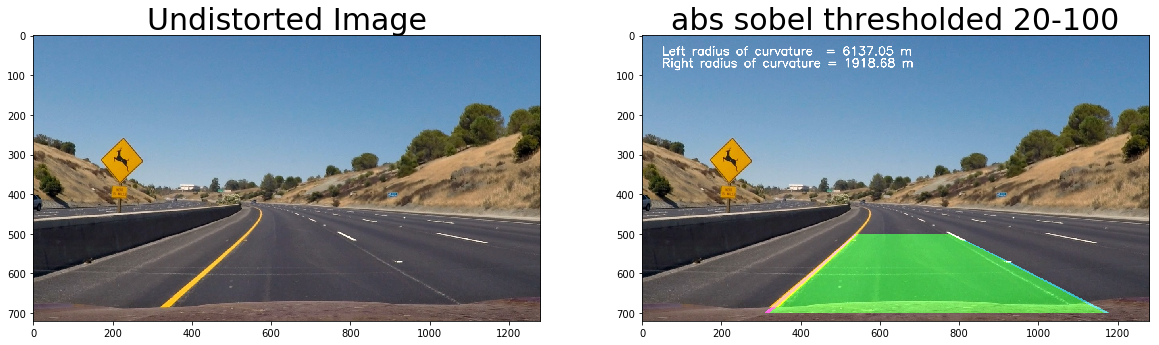

In [20]:
sample_img1 = mpimg.imread("test_images/test2.jpg")
undistort_img1 = process_image(sample_img1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(sample_img1)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(undistort_img1, cmap='gray')
ax2.set_title('abs sobel thresholded 20-100', fontsize=30)

#### Perspective Trasform

In [21]:
# src =  np.float32([[900, 450], [1200, 700], [200, 700], [500, 450]])
src =  np.float32([[850, 500], [1200, 700], [200, 700], [500, 500]])
dst = np.float32([[1280, 0], [1280, 720], [0, 720], [0, 0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def warp(image, m=M):
    warped = cv2.warpPerspective(image, m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

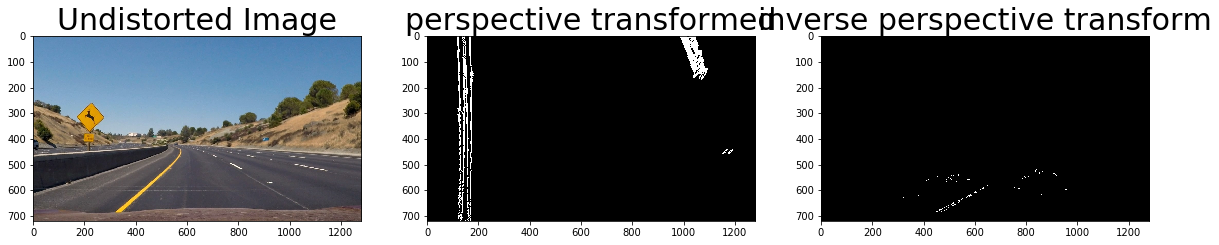

In [22]:
undistort_img2 = undistort(sample_img1, mtx, dist)
abs_sobel_img2 = abs_sobel_thresh(undistort_img2, orient='x', sobel_kernel=9, thresh_min=20, thresh_max=100)
warped_img2 = warp(abs_sobel_img2, M)
unwarped_img2 = warp(abs_sobel_img2, Minv)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(sample_img1)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped_img2, cmap='gray')
ax2.set_title('perspective transformed', fontsize=30)
ax3.imshow(unwarped_img2, cmap='gray')
ax3.set_title('inverse perspective transform', fontsize=30)

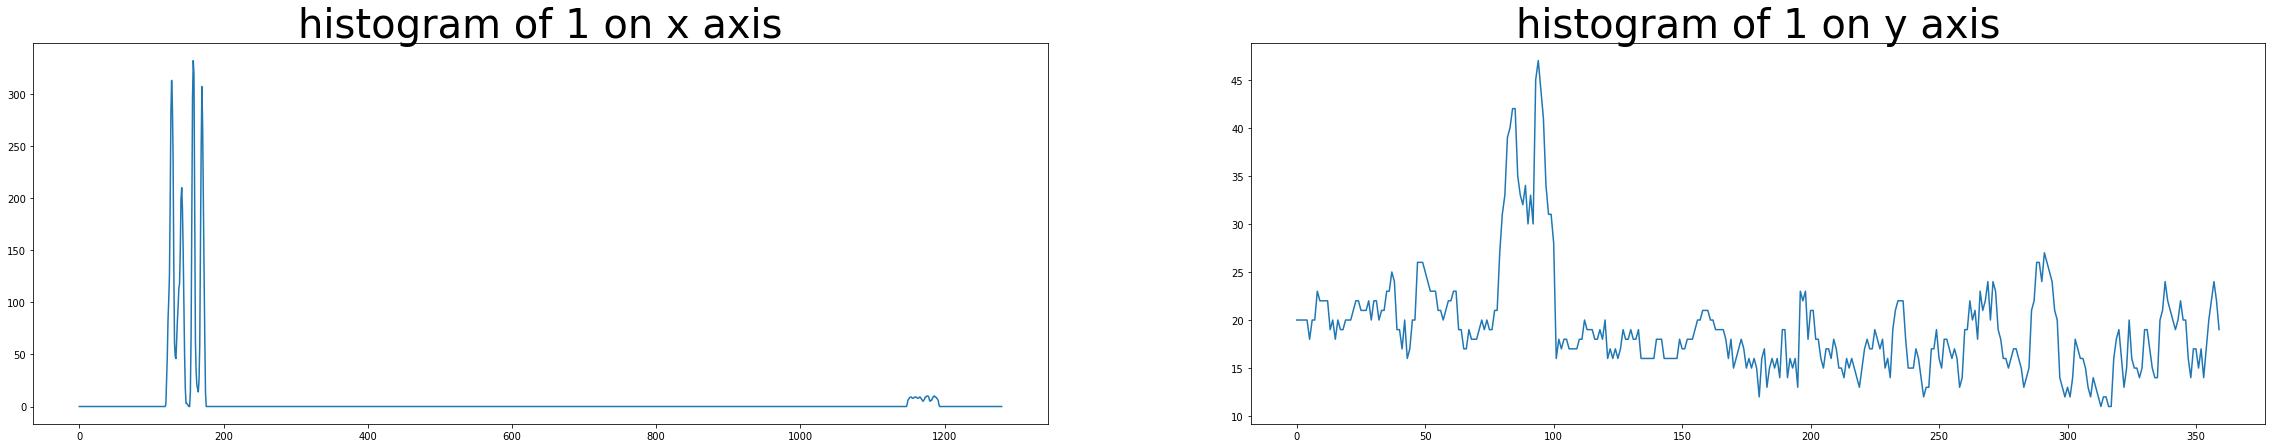

In [23]:
histogramx = np.sum(warped_img2[warped_img2.shape[0]//2:, :], axis=0)
histogramy = np.sum(warped_img2[warped_img2.shape[0]//2:, :], axis=1)

f, ax = plt.subplots(1,2, figsize=(40, 7))
ax[0].plot(histogramx)
ax[0].set_title("histogram of 1 on x axis", fontsize=40)
ax[1].plot(histogramy)
ax[1].set_title("histogram of 1 on y axis", fontsize=40)

In [45]:
i = 0
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:18<00:00,  9.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 38s, sys: 16.6 s, total: 2min 55s
Wall time: 2min 19s
